In [1]:
import keras.callbacks
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
import sklearn
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

2022-09-21 14:53:45.322744: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# 모델 구성 (multi-class classification)
# 데이터 불러오기
learn_csv_file = pd.read_csv('csv_files/side_five_class/side_learn.csv')
valid_csv_file = pd.read_csv('csv_files/side_five_class/side_valid.csv')
test_csv_file = pd.read_csv('csv_files/side_five_class/side_test.csv')

learn_csv_file = sklearn.utils.shuffle(learn_csv_file)
valid_csv_file = sklearn.utils.shuffle(valid_csv_file)

col = 34

learn_x = learn_csv_file.iloc[:,:col].values
learn_y = learn_csv_file.iloc[:,col:].values
valid_x = valid_csv_file.iloc[:,:col].values
valid_y = valid_csv_file.iloc[:,col:].values
test_x = test_csv_file.iloc[:,:col].values
test_y = test_csv_file.iloc[:,col:].values

scaler = RobustScaler()
scaler.fit(learn_x)
scaled_learn_x = scaler.transform(learn_x)
scaled_valid_x = scaler.transform(valid_x)
scaled_test_x = scaler.transform(test_x)
joblib.dump(scaler, 'trained_models/scalers/fall_scaler_robust_five_class.pkl')

# one-hot encoding
learn_y = tf.keras.utils.to_categorical(learn_y)
valid_y = tf.keras.utils.to_categorical(valid_y)
test_y = tf.keras.utils.to_categorical(test_y)

dropout_ratio = 0.5
regulation = 0.01

side_model = Sequential()

side_model.add(Dense(128, activation='relu', input_shape=(col,), kernel_regularizer=regularizers.l2(regulation)))
side_model.add(Dropout(dropout_ratio))
side_model.add(Dense(128, activation='relu', input_shape=(col,), kernel_regularizer=regularizers.l2(regulation)))
side_model.add(Dropout(dropout_ratio))
side_model.add(Dense(5, activation='softmax'))

# 모델 최적화 및 손실 함수 알고리즘 지정
# adam, crossentropy
side_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
save_best = keras.callbacks.ModelCheckpoint(filepath='trained_models/fall_model_five_class.h5', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

# 모델 training
side_model_after_data = side_model.fit(scaled_learn_x, learn_y, batch_size=64, epochs=300, validation_data=(scaled_valid_x, valid_y), callbacks=[early_stop, save_best])

# 모델 test (predict)
print()
predict_result = side_model.predict(scaled_test_x)
side_model.evaluate(scaled_test_x, test_y)
test_correct = 0
for i in range(len(test_y)):
    if test_y[i].argmax() == predict_result[i].argmax():
        test_correct += 1
print(f"test result correct percent : {test_correct/len(test_y) * 100:.2f}%")

Epoch 1/300


2022-09-21 14:53:46.653453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 14:53:46.671823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-21 14:53:46.671835: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-21 14:53:46.672242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

135/155 [=========================>....] - ETA: 0s - loss: 2.1911 - accuracy: 0.6690 - recall_m: 0.4365 - precision_m: 0.8358 - f1_m: 0.5601
Epoch 1: val_loss improved from inf to 1.36789, saving model to trained_models/fall_model_five_class.h5
155/155 [==============================] - 1s 2ms/step - loss: 2.0882 - accuracy: 0.6929 - recall_m: 0.4743 - precision_m: 0.8436 - f1_m: 0.5916 - val_loss: 1.3679 - val_accuracy: 0.8012 - val_recall_m: 0.7247 - val_precision_m: 0.8357 - val_f1_m: 0.7758
Epoch 2/300
124/155 [=======================>......] - ETA: 0s - loss: 1.0389 - accuracy: 0.8850 - recall_m: 0.8182 - precision_m: 0.9167 - f1_m: 0.8642
Epoch 2: val_loss improved from 1.36789 to 0.86148, saving model to trained_models/fall_model_five_class.h5
155/155 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.8866 - recall_m: 0.8257 - precision_m: 0.9163 - f1_m: 0.8681 - val_loss: 0.8615 - val_accuracy: 0.8413 - val_recall_m: 0.7879 - val_precision_m: 0.8620 - v

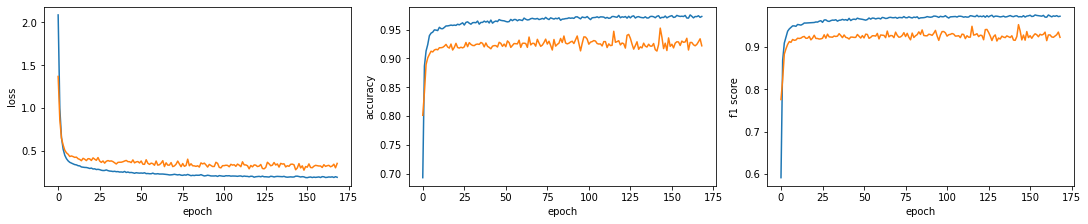

In [4]:
# 시각화
# 손실, 정확도 그래프
plt.subplots(figsize=(15, 3), constrained_layout=True)
plt.subplot(1, 3, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(side_model_after_data.history['loss'])
plt.plot(side_model_after_data.history['val_loss'])
plt.subplot(1, 3, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(side_model_after_data.history['accuracy'])
plt.plot(side_model_after_data.history['val_accuracy'])
plt.subplot(1, 3, 3)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.plot(side_model_after_data.history['f1_m'])
plt.plot(side_model_after_data.history['val_f1_m'])

plt.show()
